In [1]:
# Important libraries
import numpy as np
import nengo
import pandas as pd
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Basic Properties

In [2]:
# Change 'monkey' variable to the desired monkey dataset: MM_S1, MT_S1, MT_S2, MT_S3
monkey = "MM_S1"

# Datapath to get the raw data file (Stored in DataExtraction)
datafile_path = r"..\\..\\Data Extraction\\"+monkey+"_raw.csv"

## Getting Functional Decoders

In [59]:
def functional_decoder(file_path, test_size):
    # Load in and normalize data
    data_df = pd.read_csv(file_path)

    # Get data information
    headers = data_df.columns.tolist()
    n_neurons = sum("Neuron" in string for string in headers)
    n_kinem = 4

    # Train-test split
    # Turn shuffle off to ensure that it remains in time-series
    train_df, test_df = train_test_split(data_df, test_size=test_size, shuffle=False)
    
    # Removing Outliers
    for x in ['x_velocity', 'y_acceleration']:
        mean = train_df[x].mean()
        std = train_df[x].std()
        lower_bound = mean - 1.96 * std
        upper_bound = mean + 1.96 * std
        train_df = train_df[(train_df[x] >= lower_bound) & (train_df[x] <= upper_bound)]
        

    # Set up matrices for the decoder (training)
    activity_matrix = train_df.loc[:, 'Neuron1':f'Neuron{n_neurons}']
    kinem_matrix = train_df.loc[:, 'x_velocity':'y_acceleration']

    # Transpose data to ensure that dimensions are correct for decoder values
    tranposed_activity_matrix = activity_matrix.transpose()
    tranposed_kinem_matrix = kinem_matrix.transpose()

    A = tranposed_activity_matrix.to_numpy()  # n_neurons x n_timepoints
    Y = tranposed_kinem_matrix.to_numpy()    # n_kinematics x n_timepoints

    # Normalization

    # Velocity Normalizations
    x_vel_max = np.max(np.abs(Y[0]))
    y_vel_max = np.max(np.abs(Y[1]))
    vel_max = max(x_vel_max, y_vel_max)
    Y[0] = Y[0]/vel_max
    Y[1] = Y[1]/vel_max

    # Acceleration Normalizations
    x_acc_max = np.max(np.abs(Y[2]))
    y_acc_max = np.max(np.abs(Y[3]))
    acc_max = max(x_acc_max, y_acc_max)
    Y[2] = Y[2]/acc_max
    Y[3] = Y[3]/acc_max
    
    # Calculat standard deviation of activity matrix
    activity_std = np.std(A)

    # Compute decoders
    D = np.linalg.lstsq(A @ A.T, A @ Y.T, rcond=None)[0].T
    D_reg = np.linalg.lstsq(A @ A.T + A.shape[1] * np.square(np.random.normal(0, activity_std, 1)) * np.eye(n_neurons), A @ Y.T, rcond=None)[0].T


    # Set up matrices for the decoder (testing set)
    test_activity_matrix = test_df.loc[:, 'Neuron1':f'Neuron{n_neurons}']
    test_kinem_matrix = test_df.loc[:, 'x_velocity':'y_acceleration']
    test_tranposed_activity_matrix = test_activity_matrix.transpose()
    test_tranposed_kinem_matrix = test_kinem_matrix.transpose()

    A_test = test_tranposed_activity_matrix.to_numpy()  # n_neurons x n_timepoints
    Y_test = test_tranposed_kinem_matrix.to_numpy()     # n_kinematics x n_timepoints

    # Predictions for testing data
    Y_hat_test = D @ A_test
    Y_hat_reg_test = D_reg @ A_test

    # Function to calculate errors
    def GetErrors(Y_, Y_HAT):

        x_velocity_rmse = np.sqrt(np.square(np.subtract(Y_[0] /vel_max, Y_HAT[0])).mean())
        y_velocity_rmse = np.sqrt(np.square(np.subtract(Y_[1] /vel_max, Y_HAT[1])).mean())
        x_acceleration_rmse = np.sqrt(np.square(np.subtract(Y_[2] /acc_max, Y_HAT[2])).mean())
        y_acceleration_rmse = np.sqrt(np.square(np.subtract(Y_[3] /acc_max, Y_HAT[3])).mean())
        return (x_velocity_rmse, y_velocity_rmse, x_acceleration_rmse, y_acceleration_rmse)

    # Verifying Functional Decoder
    decoder_error_test = GetErrors(Y_test, Y_hat_test)
    print("Non-Regularized Decoder Errors (Testing):")
    print(f"X Velocity RMSE: {decoder_error_test[0]}")
    print(f"Y Velocity RMSE: {decoder_error_test[1]}")
    print(f"X Acceleration RMSE: {decoder_error_test[2]}")
    print(f"Y Acceleration RMSE: {decoder_error_test[3]}")

    decoder_reg_error_test = GetErrors(Y_test, Y_hat_reg_test)
    print("Regularized Decoder Errors (Testing):")
    print(f"X Velocity RMSE: {decoder_reg_error_test[0]}")
    print(f"Y Velocity RMSE: {decoder_reg_error_test[1]}")
    print(f"X Acceleration RMSE: {decoder_reg_error_test[2]}")
    print(f"Y Acceleration RMSE: {decoder_reg_error_test[3]}")

    return D, D_reg, A_test, Y_test, vel_max, acc_max

In [60]:
decoder, decoder_reg, test_spikes, test_kinematic, velocity_scale, acceleration_scale = functional_decoder(datafile_path, 0.4)

Non-Regularized Decoder Errors (Testing):
X Velocity RMSE: 0.18023826485516983
Y Velocity RMSE: 0.18037273904855217
X Acceleration RMSE: 0.16469411848125637
Y Acceleration RMSE: 0.1825429734661727
Regularized Decoder Errors (Testing):
X Velocity RMSE: 0.18023102774088318
Y Velocity RMSE: 0.18037230156156414
X Acceleration RMSE: 0.16468939023401855
Y Acceleration RMSE: 0.182538051066963


## Quick Stats

In [ ]:
spikes = test_spikes
dt = 0.001
dti = 1/dt
spikes = spikes*dti

# Parameters to change
n_ensemble_neurons = 5000
ensemble_radius = 1
ensemble_decoder = decoder_reg
ensemble_synapse = 0.025
probe_synapse = 0.01

## Nengo Model

Build finished in 0:00:04.                                                      
Simulation finished in 0:00:04.                                                 


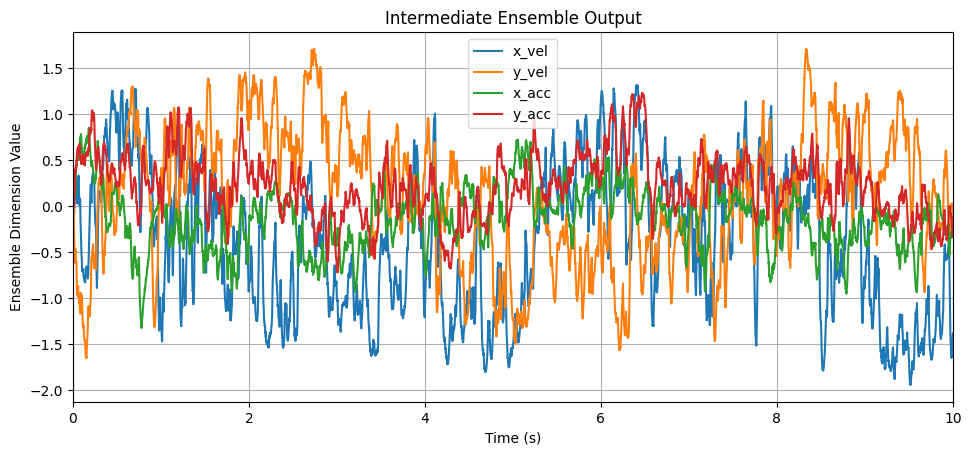

In [ ]:
# Nengo Network Using Recorded Spikes as Input
np.random.seed(0)
with nengo.Network() as model:
    input_node = Node(lambda t: spikes[:,int(t / dt) - 1])
    ensemble = Ensemble(n_neurons=n_ensemble_neurons, dimensions=4, radius = ensemble_radius)
    connector = Connection(input_node, ensemble, transform=ensemble_decoder, synapse=ensemble_synapse)
    p_post = nengo.Probe(ensemble, synapse=probe_synapse) # A probe enables us to assess the simulation data for a specific model component

with nengo.Simulator(model, dt=dt, seed=0) as sim:
    sim.run(10)

fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_post])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_vel", "y_vel", "x_acc", "y_acc"])
pl.grid()

# Velocity Comparisons

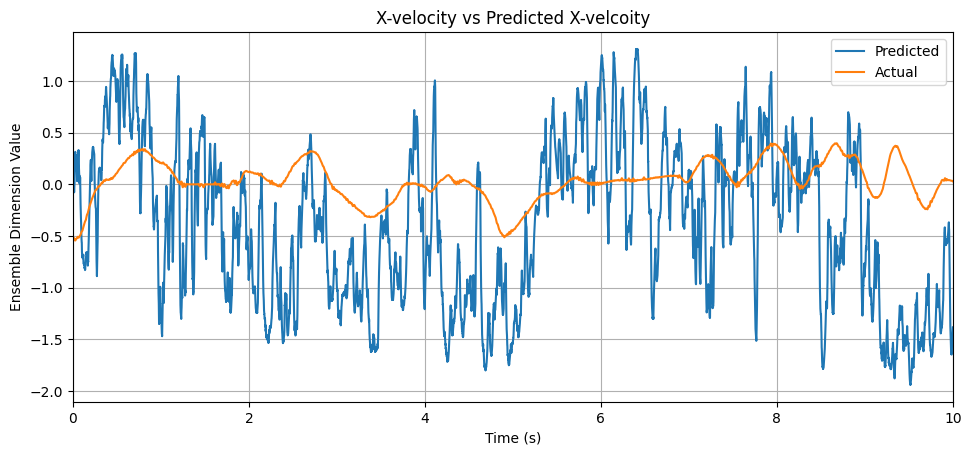

In [63]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_post][:, 0])
pl.plot(sim.trange(), test_kinematic[0, 0:len(sim.trange())]/velocity_scale)
pl.set_title("X-velocity vs Predicted X-velcoity")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Predicted", "Actual"])
pl.grid()

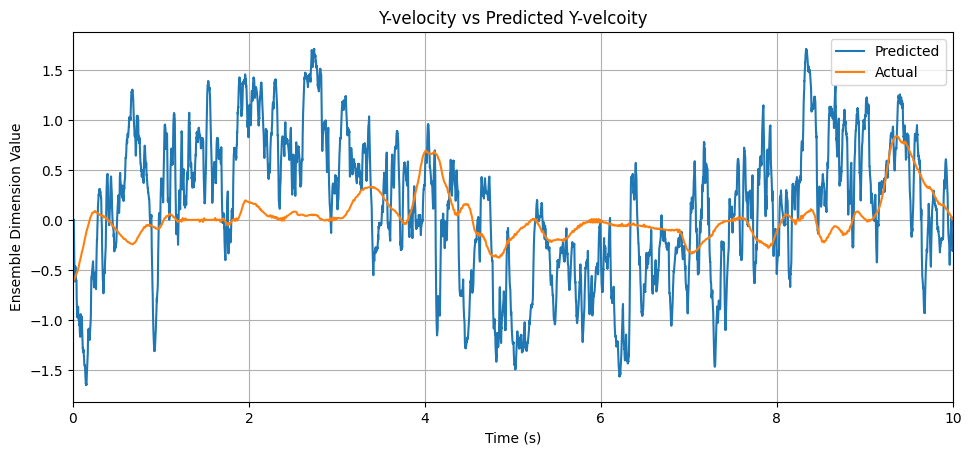

In [64]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_post][:, 1])
pl.plot(sim.trange(), test_kinematic[1, 0:len(sim.trange())]/velocity_scale)
pl.set_title("Y-velocity vs Predicted Y-velcoity")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Predicted", "Actual"])
pl.grid()

## Acceleration Comparisons

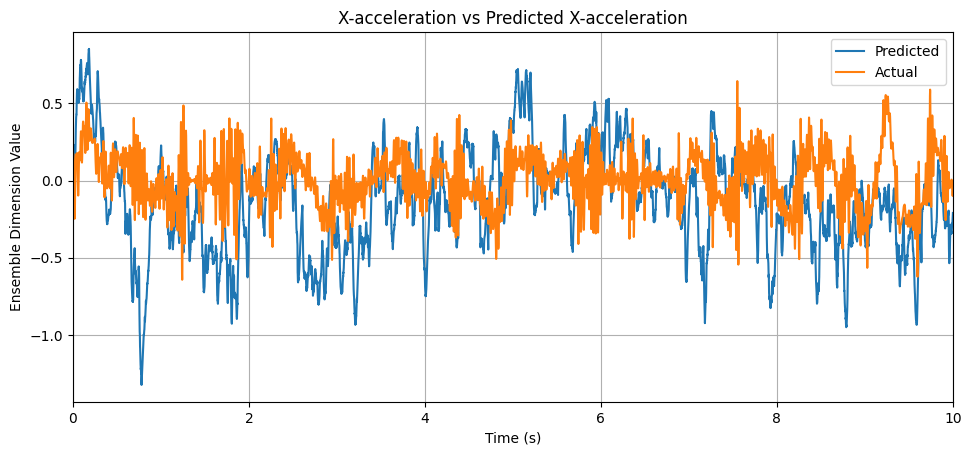

In [65]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_post][:, 2])
pl.plot(sim.trange(), test_kinematic[2, 0:len(sim.trange())]/acceleration_scale)
pl.set_title("X-acceleration vs Predicted X-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Predicted", "Actual"])
pl.grid()

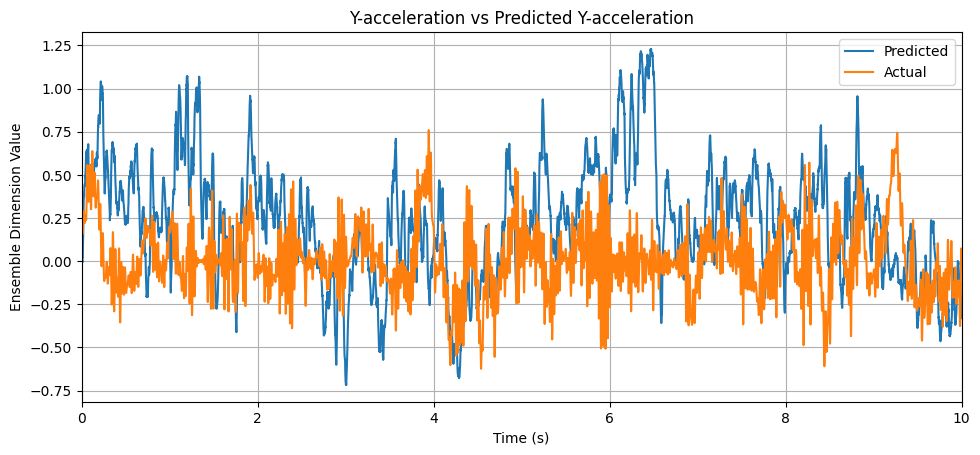

In [66]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_post][:, 3])
pl.plot(sim.trange(), test_kinematic[3, 0:len(sim.trange())]/acceleration_scale)
pl.set_title("Y-acceleration vs Predicted Y-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Predicted", "Actual"])
pl.grid()